In [2594]:
import os
import time

import numpy as np
import pandas as pd

from scipy.special import erf
from scipy.special import erfc
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

from IPython import display

In [2587]:
class StopAssay(Exception): pass

In [ ]:
wave_df = pd.DataFrame()
fits_df = pd.DataFrame(index=["upper_fit", "lower_fit", "sigma_fit", "x0_fit"])
x0_list = [0]
v_list = [0]
window = 8
pts_for_reg = {}

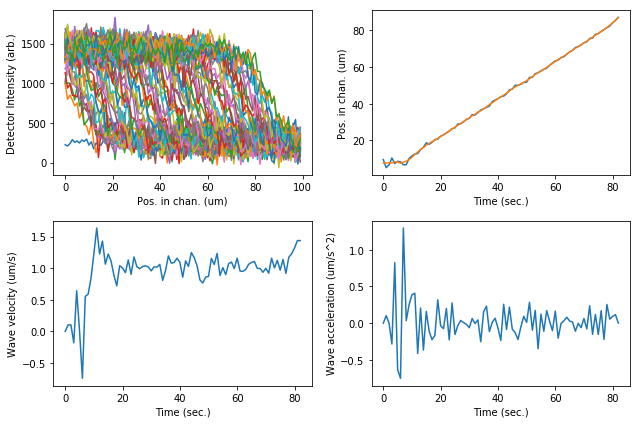

Recording data point for regression...
Assay complete
Antigen concentration: 103.21359831888317 nM


In [2649]:
###
#Script that automatically generates wave data, 
#analyzes that data, and stops the assay once 
#sufficient data points have been collected
###

wave_df = pd.DataFrame()
fits_df = pd.DataFrame(index=["upper_fit", "lower_fit", "sigma_fit", "x0_fit"])
x0_list = [0]
v_list = [0]
window = 8
pts_for_reg = {}
starttime = time.time()

while True:
    
    #Generate wave data
    wave_generator(1200, 250, 50, 1, 3, v_list, wave_df, x0_list)
    
    #Fit wave data to sigmoidal equation and extract parameters
    x0_fit, x0_savgol, v_fit, dvdt = wave_analyzer(wave_df, fit_func)
    
    #Plot data and parameters
    display.clear_output(wait=True)
    wave_plotter(wave_df, x0_fit, v_fit, dvdt)
    
    #Identify points in linear regime, stop assay when assay is complete
    try:
        pts_for_reg = assay_analyzer(x0_savgol, dvdt, window, pts_for_reg)
    except StopAssay:
        break
    else:    
        time.sleep(1.0 - ((time.time() - starttime) % 1.0))
        

In [611]:
def wave_generator(upper, lower, sigma, v_final, v_acc, v_list, wave_df, x0_list, t_step=1, x_range=100):
    
    x_pos = [pos for pos in range(x_range)]
    I_list = []
    
    if wave_df.empty:
        for x in range(x_range):
            I = lower
            I_list.append(I)
    
        np.random.seed(int(time.time()))
        noise = lower/10*np.random.normal(size=x_range)
        I_noise = I_list + noise
        wave_df["0"] = I_noise
    
    else:
        t = len(wave_df.columns)*t_step + t_step
        v = vel_generator(v_list[-1], v_final, v_acc)
        x0 = x0_list[-1] + v*t_step

        upper_adj = random_fluxor(upper)
        lower_adj = random_fluxor(lower)
        sigma_adj = random_fluxor(sigma)

        #calculate at each point

        for x in x_pos:
            I_erf = 0.5 - 0.5*erf((x - x0)/np.sqrt(2*sigma_adj))
            I = upper_adj*I_erf + lower_adj
            I_list.append(I)

        np.random.seed(int(time.time()))
        noise = (upper-lower)/10*np.random.normal(size=x_range)
        I_noise = I_list + noise

        wave_df[t] = I_noise
        x0_list.append(x0)
        v_list.append(v)

    #print(t, v, x0, upper_adj, lower_adj, sigma_adj)
    #print(I_list)
    #plt.plot(I_noise)
wave_generator(1200, 250, 30, 2, 0.3, v_list, wave_df, x0_list)

In [1176]:
def wave_analyzer(wave_df, fit_func):
    popt, pcov = fit_wave(fit_func, wave_df)
    
    curr_t = len(wave_df.columns)-1
    
    fits_df[curr_t] = popt
    
    x0_fit = fits_df.loc["x0_fit"]
    
    sg_window = 5
    
    if len(x0_fit) < sg_window:

        x0savgol = np.nan
        v_fit = np.nan
        dvdt = np.nan
        
        return x0_fit, x0savgol, v_fit, dvdt


    else:
        x0_savgol = savgol_filter(x0_fit, sg_window, 1)
    
        v_fit = time_deriv(x0_savgol, x0_fit.index.values)

        dvdt = time_deriv(v_fit, x0_fit.index.values)
        
        return x0_fit, x0_savgol, v_fit, dvdt

In [2644]:
def wave_plotter(wave_df, x0_fit, v_fit, dvdt):
    fig = plt.figure(figsize=(9, 6))
    
    plt.subplot(221, xlabel=r"Pos. in chan. (um)", ylabel=r"Detector Intensity (arb.)")
    plt.plot(wave_df)
    
    plt.subplot(222, xlabel=r"Time (sec.)", ylabel=r"Pos. in chan. (um)")
    plt.plot(x0_fit)
    plt.plot(x0_savgol)
    
    plt.subplot(223, xlabel=r"Time (sec.)", ylabel=r"Wave velocity (um/s)")
    plt.plot(v_fit)
    
    plt.subplot(224, xlabel=r"Time (sec.)", ylabel=r"Wave acceleration (um/s^2)")
    plt.plot(dvdt)

    fig.tight_layout()
    plt.show()

In [2616]:
def assay_analyzer(x0_savgol, dvdt, window, pts_for_reg):
    
    if x0_fit[-1:].item() > 90:
        print("Assay complete")
        if len(pts_for_reg) > 30:
            return calc_conc(pts_for_reg)
        else:
            print("Concentration out of range")
            raise StopAssay("Concentration out of range")
    
    else:
        pts_to_add = pick_reg_points(dvdt, window)
        
        if len(pts_for_reg) > 30:
            print("Assay complete")
            return calc_conc(pts_for_reg)
        
        if type(pts_to_add) is not dict:
            pts_for_reg[len(x0_savgol)] = float(x0_savgol[-1])
            return pts_for_reg

        else:
            return {}

In [ ]:
wave_generator(1200, 250, 30, 2, 0.5, v_list, wave_df, x0_list)
x0_fit, x0_savgol, v_fit, dvdt = wave_analyzer(wave_df, fit_func)
wave_plotter(wave_df, x0_fit, v_fit, dvdt)
pts_for_reg = assay_analyzer(x0_savgol, dvdt, window, pts_for_reg)

#plt.plot(x0_fit)
#plt.plot(v_fit)
#plt.plot(dvdt)

In [2494]:
def pick_reg_points(dvdt, window, tolerance=0.05):
    
    try:
        len(dvdt)
    
    except TypeError:
        print("Analysis starting, please collect more data...")
        return {}
    
    else: 
        dvdt_avg = moving_avg(dvdt, window)

        if type(dvdt_avg) == str:
            print('Window wider than current data')
            return {}
        
        elif abs(dvdt_avg) < abs(tolerance):    
            print("Recording data point for regression...")
            return x0_savgol[-1]

        else:
            print("Too much error")
            return {}

In [2588]:
def calc_conc(pts_for_reg,
              Ufluid = 100e-6, 
              nw = 2, 
              h = 200e-9, 
              Cs0 = 1e-9, 
              Kd = 1e-6):
    
    #sm.add_constant needed to include intercept in regression
    reg_df = pd.DataFrame(list(pts_for_reg.items()), columns=["time", "x0"])
    mod = sm.OLS(reg_df.x0, sm.add_constant(reg_df.time))
    res = mod.fit()
    v_reg = res.params.time #um/s
    v_stderr = res.bse.time

    v_eff = v_reg*1e-6
    Cb0 = 1/(((Ufluid/v_eff) - 1) * h/(nw * Cs0))-Kd
    
    print("Antigen concentration:", Cb0/1000/1e-9, "nM")
    raise StopAssay("The assay is complete. Stopping measurement")

In [261]:
def fit_func(x, upper_fit, lower_fit, sigma_fit, x0_fit):
    return upper_fit*(0.5 - 0.5*erf((x - x0_fit)/np.sqrt(2*sigma_fit))) + lower_fit

In [ ]:
def fit_wave(fit_func, wave_df):
    popt, pcov = curve_fit(fit_func, 
                       wave_df.index.values, 
                       wave_df.iloc[:,-1].values,
                       bounds=(0, [10000, 2000, 100, 100]))
    return popt, pcov

In [20]:
def time_deriv(x, t):
    deriv = []
    for i in range(len(x)):
        if i == 0:
            deriv.append(0)
            continue
        dx = (x[i] - x[i-1])
        dt = (t[i] - t[i-1])
        dxdt = dx/dt
        deriv.append(dxdt)
    return deriv

In [1274]:
def moving_avg(x, window):
    
    try:
        curr = len(x)
    except TypeError:
        "Analysis starting, please collect more data..."
        
    else:
        if window > curr:
            return "window wider than current data"

        else:
            avg = np.average(x[-window:])

            #avg = np.average(x[curr:curr-window-1:-1])

        return avg

In [114]:
def moving_avg_np(x, window):
    
    for i in range(len(x)):
        if window > i:
            print("window wider than current data")
            continue
        print(np.average(x[i-window:i:1]))

In [18]:
def random_fluxor(x):
    return x*(1+(np.random.random()-0.5)/10)

In [19]:
def vel_generator(v, v_final, v_acc):
    if v < v_final:
        v = v+v_acc*np.random.random()
        return v
    else:
        v = v_final*(1+np.random.random()/20)
    return v

In [ ]:
def calc_vel(Cb0,
            Ufluid = 100e-6, 
            nw = 2, 
            h = 200e-9, 
            Cs0 = 1e-9, 
            Kd = 1e-6):


    v_eqn = Ufluid/(1 + (nw * Cs0)/(h * (Cb0 + Kd)))
    return v_eqn

In [1916]:
def wave_regressor(dvdt, window, tolerance=0.05):
    
    try:
        len(dvdt)
    
    except TypeError:
        print("Analysis starting, please collect more data...")
        return (None, None, None)
    
    else: 
        dvdt_avg = moving_avg(dvdt, window)

        if type(dvdt_avg) == str:
            print('Window wider than current data')
            return (None, None, None)
        
        elif abs(dvdt_avg) < abs(tolerance):    
            print(dvdt_avg, "<", tolerance)
            x0_lr_range.append(len(x0_savgol) - window)


            X = np.array(x0_lr_range).reshape(-1, 1)
            y = x0_fit[x0_lr_range]
            reg = LinearRegression().fit(X, y)
            
            reg_line = reg.predict(X)

            return reg.score(X, y), reg.coef_, reg_line

        else:
            print("Too much error")
            return (None, None, None)